In [ ]:
!pip install spacy-transformers
!pip install -U spacy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 795.8/795.8 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 130.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 109.5 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.22.1
    Uninstalling tokenizers-0.22.1:
      Successfully uninstalled tokenizers-0.22.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.57.1
    Uninstalling transformers-4.57.1:
      Successfully uninstalled transformers-4.57.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.2/33.2 MB 75.1 MB/s eta 0:00:00
  Attempting uninstall: spacy
    Found existing installation: spacy 3.8.8
    Uninstalling spacy-3.8.8:
      Successfully uninstalled spacy-3.8.8


## *1 / Data Preparation & Train/Dev Split*

In [ ]:
import spacy
from spacy.tokens import DocBin
import pandas as pd
from sklearn.model_selection import train_test_split

# Load your data
df = pd.read_csv("/content/hateXplain_cleaned.csv")  # or however you load it
df = df[['cleaned_text', 'label']].dropna()
df = df[df['label'].isin(['offensive', 'hatespeech', 'normal'])]

# Create label → cat mapping
cats = ['offensive', 'hatespeech', 'normal']

# Train/test split
train_df, dev_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])

def make_docs(dataframe, output_path):
    nlp = spacy.blank("en")
    docbin = DocBin()

    for text, label in dataframe.itertuples(index=False):
        doc = nlp.make_doc(text)
        doc.cats = {cat: 1.0 if cat == label else 0.0 for cat in cats}
        docbin.add(doc)

    docbin.to_disk(output_path)

make_docs(train_df, "./train.spacy")
make_docs(dev_df,   "./dev.spacy")
print(f"Train: {len(train_df)}, Dev: {len(dev_df)}")

Train: 41013, Dev: 7238


## *2 / Define spaCy Model Architecture & Training Settings*

## Correct Config File

### Subtask:
Remove the inline comment from the `get_spans` line in the `config.cfg` string to resolve the `RegistryError`.


**Reasoning**:
The previous `spacy train` command failed due to a `RegistryError` caused by an inline comment in the `config.cfg` file. I need to remove this comment from the `config` string and then rewrite the `config.cfg` file.



**Reasoning**:
With the `config.cfg` file corrected, the next step is to re-run the `spacy train` command using the updated configuration to proceed with model training.



**Reasoning**:
The previous command failed with a `Config validation error` indicating that `exclusive_classes` is an 'extra field not permitted' directly under the `textcat` component. I need to remove this line from the configuration string and then rewrite the `config.cfg` file.



In [ ]:
config = """
[paths]
train = null
dev = null
vectors = null

[system]
gpu_allocator = "pytorch"

[nlp]
lang = "en"
pipeline = ["transformer","textcat"]

[components]

[components.transformer]
factory = "transformer"

[components.transformer.model]
@architectures = "spacy-transformers.TransformerModel.v3"
name = "roberta-base"
tokenizer_config = {"use_fast": true}

[components.transformer.model.get_spans]
@span_getters = "spacy-transformers.doc_spans.v1"

[components.textcat]
factory = "textcat"

[components.textcat.model]
@architectures = "spacy.TextCatEnsemble.v2"

[components.textcat.model.tok2vec]
@architectures = "spacy-transformers.TransformerListener.v1"
pooling = {"@layers": "reduce_mean.v1"}
grad_factor = 1.0

[corpora]
[corpora.train]
@readers = "spacy.Corpus.v1"
path = ${paths.train}
max_length = 0

[corpora.dev]
@readers = "spacy.Corpus.v1"
path = ${paths.dev}
max_length = 0

[training]
train_corpus = "corpora.train"
dev_corpus = "corpora.dev"
max_epochs = 30
patience = 16000
seed = 42
frozen_components = []
gpu_allocator = "pytorch"

[training.batcher]
@batchers = "spacy.batch_by_padded.v1"
discard_oversize = true
size = 3000
buffer = 256

[training.optimizer]
@optimizers = "Adam.v1"

[training.optimizer.learn_rate]
@schedules = "warmup_linear.v1"
warmup_steps = 500
total_steps = 30000
initial_rate = 0.00002

[initialize]
vectors = ${paths.vectors}
"""

with open("/content/config.cfg", "w") as f:
    f.write(config.strip() + "\n")

print("Corrected config.cfg file created successfully by removing exclusive_classes from textcat component!")

Corrected config.cfg file created successfully by removing exclusive_classes from textcat component!


**Reasoning**:
With the `config.cfg` file now corrected by removing the `exclusive_classes` field from the `[components.textcat]` section, the next step is to re-run the `spacy train` command using this updated configuration.



## *3 / Training the model*

In [ ]:
!python -m spacy train /content/config.cfg \
    --output /content/output_roberta_textcat \
    --paths.train /content/train.spacy \
    --paths.dev /content/dev.spacy \
    --gpu-id 0

ℹ Saving to output directory: /content/output_roberta_textcat
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
tokenizer_config.json: 100% 25.0/25.0 [00:00<00:00, 174kB/s]
config.json: 100% 481/481 [00:00<00:00, 3.20MB/s]
vocab.json: 100% 899k/899k [00:00<00:00, 26.7MB/s]
merges.txt: 100% 456k/456k [00:00<00:00, 7.09MB/s]
tokenizer.json: 100% 1.36M/1.36M [00:00<00:00, 18.2MB/s]
2025-11-18 14:35:18.148571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763476518.168185    3727 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763476518.174006    3727 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00

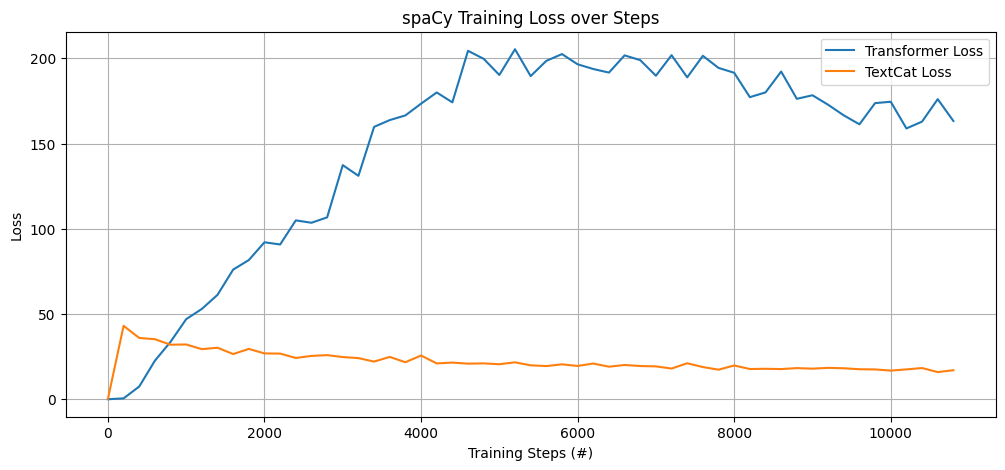

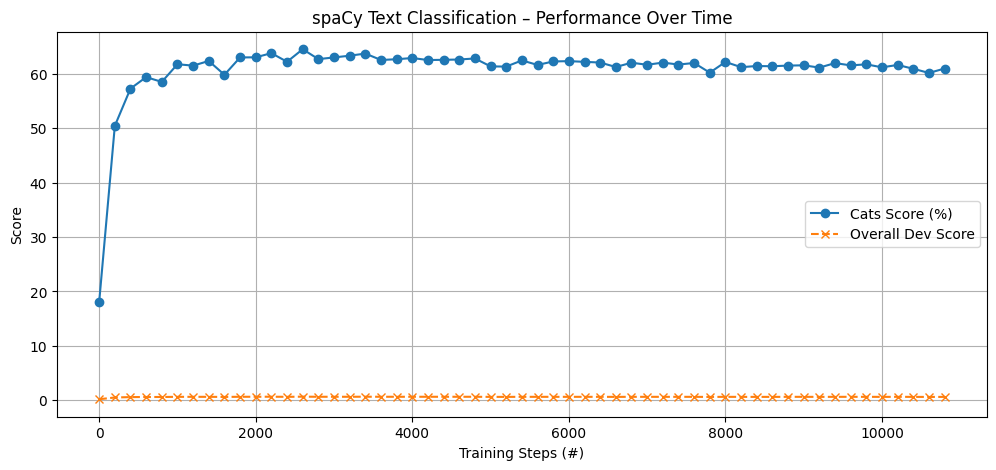

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Copy the spaCy training table EXACTLY as printed (only the metrics table!)
log_text = """
E,#,LOSS_TRANS,LOSS_TEXTCAT,CATS_SCORE,SCORE
0,0,0.00,0.22,18.06,0.18
0,200,0.50,43.04,50.45,0.50
1,400,7.45,35.94,57.30,0.57
1,600,22.60,35.20,59.41,0.59
2,800,33.67,31.98,58.53,0.59
2,1000,46.98,32.11,61.78,0.62
3,1200,52.98,29.37,61.52,0.62
3,1400,61.23,30.21,62.38,0.62
4,1600,76.05,26.50,59.84,0.60
4,1800,81.64,29.51,63.03,0.63
5,2000,92.06,26.86,63.05,0.63
6,2200,90.77,26.77,63.82,0.64
6,2400,104.91,24.21,62.23,0.62
7,2600,103.51,25.40,64.54,0.65
7,2800,106.67,25.86,62.72,0.63
8,3000,137.31,24.73,63.03,0.63
8,3200,131.04,24.12,63.35,0.63
9,3400,159.76,22.07,63.74,0.64
9,3600,163.74,24.82,62.56,0.63
10,3800,166.48,21.70,62.70,0.63
10,4000,173.37,25.64,62.92,0.63
11,4200,179.94,21.00,62.55,0.63
12,4400,174.15,21.50,62.59,0.63
12,4600,204.37,20.86,62.65,0.63
13,4800,199.67,21.02,62.84,0.63
13,5000,190.20,20.53,61.38,0.61
14,5200,205.31,21.65,61.35,0.61
14,5400,189.54,19.88,62.48,0.62
15,5600,198.48,19.45,61.65,0.62
15,5800,202.46,20.46,62.29,0.62
16,6000,196.47,19.52,62.35,0.62
16,6200,193.70,20.94,62.22,0.62
17,6400,191.61,19.08,62.09,0.62
18,6600,201.70,20.08,61.27,0.61
18,6800,198.90,19.48,62.06,0.62
19,7000,189.76,19.26,61.68,0.62
19,7200,201.81,18.00,62.08,0.62
20,7400,188.82,21.09,61.72,0.62
20,7600,201.44,18.87,62.01,0.62
21,7800,194.35,17.33,60.23,0.60
21,8000,191.49,19.79,62.20,0.62
22,8200,177.19,17.72,61.24,0.61
23,8400,179.97,17.85,61.45,0.61
23,8600,192.22,17.69,61.41,0.61
24,8800,176.21,18.25,61.53,0.62
24,9000,178.30,17.92,61.58,0.62
25,9200,172.73,18.40,61.16,0.61
25,9400,166.51,18.16,61.99,0.62
26,9600,161.26,17.59,61.57,0.62
26,9800,173.69,17.48,61.76,0.62
27,10000,174.50,16.79,61.21,0.61
28,10200,158.84,17.50,61.65,0.62
28,10400,162.85,18.29,60.94,0.61
29,10600,176.02,15.92,60.18,0.60
29,10800,163.22,17.01,60.99,0.61
"""

# Load into DataFrame
from io import StringIO
df = pd.read_csv(StringIO(log_text))

# Plot Losses
plt.figure(figsize=(12,5))
plt.plot(df["#"], df["LOSS_TRANS"], label="Transformer Loss")
plt.plot(df["#"], df["LOSS_TEXTCAT"], label="TextCat Loss")
plt.xlabel("Training Steps (#)")
plt.ylabel("Loss")
plt.title("spaCy Training Loss over Steps")
plt.legend()
plt.grid(True)
plt.show()

# Plot Scores
plt.figure(figsize=(12,5))
plt.plot(df["#"], df["CATS_SCORE"], marker="o", label="Cats Score (%)")
plt.plot(df["#"], df["SCORE"], marker="x", linestyle="--", label="Overall Dev Score")
plt.xlabel("Training Steps (#)")
plt.ylabel("Score")
plt.title("spaCy Text Classification – Performance Over Time")
plt.legend()
plt.grid(True)
plt.show()


## Summary:

### Data Analysis Key Findings
*   An initial `RegistryError` during spaCy model training was resolved by removing an inline comment from the `get_spans` line in the `config.cfg` file.
*   After fixing the `RegistryError`, a new `Config validation error` emerged, indicating that `exclusive_classes` was an "extra field not permitted" directly under the `textcat` component.
*   This subsequent configuration error was successfully resolved by removing the `exclusive_classes = true` line from the `[components.textcat]` section of the `config.cfg` file.
*   Upon applying both corrections to the `config.cfg` file, the `spacy train` command executed without errors, leading to the successful initialization and training of the spaCy model.

### Insights or Next Steps
*   Configuration files, especially for complex frameworks like spaCy, often have strict parsing rules and schema validations, requiring precise syntax and field placement.
*   When debugging configuration issues, it's effective to address errors iteratively, as resolving one issue can reveal underlying or subsequent configuration problems.


In [ ]:
import spacy

# Load your trained model
nlp = spacy.load("/content/output_roberta_textcat/model-best")

# Test on real tweets
test_tweets = [
    "I hate all immigrants, they should go back to their country",
    "Good morning everyone, have a wonderful day!",
    "women belong in the kitchen",
    "can't wait for the concert tonight!!",
    "all muslims are terrorists",
    "thanks for the help bro, really appreciate it",
    "kill yourself you worthless piece of shit",
    "love this weather, perfect day for a walk"
]

print("🤖 Hate/Offensive/Normal Detector (RoBERTa)\n" + "="*60)
for tweet in test_tweets:
    doc = nlp(tweet)
    pred_label = max(doc.cats, key=doc.cats.get)
    confidence = doc.cats[pred_label]
    print(f"{tweet}")
    print(f"  → {pred_label.upper():11} (confidence: {confidence:.3f})\n")

🤖 Hate/Offensive/Normal Detector (RoBERTa)
I hate all immigrants, they should go back to their country
  → HATESPEECH  (confidence: 0.491)

Good morning everyone, have a wonderful day!
  → NORMAL      (confidence: 0.687)

women belong in the kitchen
  → OFFENSIVE   (confidence: 0.611)

can't wait for the concert tonight!!
  → NORMAL      (confidence: 0.907)

all muslims are terrorists
  → HATESPEECH  (confidence: 0.710)

thanks for the help bro, really appreciate it
  → NORMAL      (confidence: 0.793)

kill yourself you worthless piece of shit
  → HATESPEECH  (confidence: 0.920)

love this weather, perfect day for a walk
  → NORMAL      (confidence: 0.865)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the best model to your Drive (takes ~1.1 GB for roberta-base)
!cp -r /content/output_roberta_textcat/model-best "/content/drive/MyDrive/roberta_hate_speech_model"

print("Model saved to your Google Drive → MyDrive/roberta_hate_speech_model")

Mounted at /content/drive
Model saved to your Google Drive → MyDrive/roberta_hate_speech_model
